Step 0. preparation

Step 1. select and plot data

Step 2. calculate b-value


# Step 0.1 Download data from NCEDC

1. go to website: https://www.ncedc.org/ncedc/catalog-search.html
2. choose "Double-difference catalog" in a "readable format"
3. setup parameters for data download (in this example, I choose data in the Bay area with latitude 37 to 38.5, longitude -123 to -121, magnitude 0-9, time 2019/01/01 to 2022/10/12). Note that increase the line limit to obtain all requested events
4. save the data to the directory you prefer (here we use dbsearch.Bay.test.txt)




# Step 0.2 install packages used for analysis

In [1]:
!pip install obspy 
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.4 MB 4.9 MB/s 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.8 MB 4.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 42.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 38.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 10.8 MB 40.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
     |████████████████████████████████| 12.1 MB 33.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.1 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m

# Step 1.1 import packages and setup parameters for later use

In [ ]:
import warnings
warnings.filterwarnings('ignore') # ignore warnings
import numpy as np
import matplotlib as mpl
from matplotlib.pyplot import *
%matplotlib inline 
# plot inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png') # output figure in png format
import matplotlib.pyplot as plt
from obspy.core.utcdatetime import UTCDateTime #convert time to UTC time
mpl.rcParams['figure.dpi']= 500 # setup the figure resolution


# add the google drive directory into path
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/traffic_light_project/'

Mounted at /content/drive


# Step 1.2 load fault data and earthquake data

In [ ]:
qfault=np.loadtxt(path+'qfaults.txt')
# fault data from USGS website

In [ ]:
year = []
lat = []
lon = []
dep = []
mag = []
evid = []
time_utc = []
time_year = []
fid = open(path+'dbsearch.Bay.test.txt')
# read in the header
line = fid.readline()
print(line)
line = fid.readline()
print(line)

#read in event lines
num = 0
for line in fid:
    num = num + 1
    if num%1000 == 0:
        print(num)
    info = line.split()
    if len(info) <2:
        continue
    iyear = int(info[0][:4])
    ilat = float(info[2])
    ilon = float(info[3])
    idep = float(info[4])
    imag = float(info[5])
    ievid = int(info[-1])
    itime_utc = float(UTCDateTime(info[0]+'T'+info[1]))
    itime_year = iyear + (itime_utc-float(UTCDateTime(iyear,1,1)))/(float(UTCDateTime(iyear+1,1,1)-float(UTCDateTime(iyear,1,1))))

    year.append(iyear)
    lat.append(ilat)
    lon.append(ilon)
    dep.append(idep)
    mag.append(imag)
    evid.append(ievid)
    time_utc.append(itime_utc)
    time_year.append(itime_year)
  
# convert list into array
year = np.asarray(year)
lat = np.asarray(lat)
lon = np.asarray(lon)
dep = np.asarray(dep)
mag = np.asarray(mag)
evid = np.asarray(evid)
time_utc = np.asarray(time_utc)
time_year = np.asarray(time_year)

Date       Time              Lat        Lon   Depth   Mag Magt  Nst Gap  Clo  RMS  SRC   Event ID

-------------------------------------------------------------------------------------------------

1000
2000
3000
4000


# Step 1.3 overview of data and select events in a certain polygon


In [ ]:
def convert(lat_all,lon_all,lat0,lon0,azimuth,mdist,halfwidth=10):
    # Input:
    # lat_all: latitude of all points
    # lon_all: longitude of all points
    # lat0, lon0 : starting point location for the projection
    # azimuth: azimuth of the projection
    # mdist: distance along the projection from lat0,lon0
    # halfwidth: half width from the projection line
    
    # Output:
    # dist_along_all, dist_norm_all: distance along and normal to the projection
    # mlat, mlon: end point of the projection
    # box_coor: coordinates of the selected polygon
    import math
    x_all = (lon_all-lon0)*40000*np.cos((lat_all+lat0)*np.pi/360)/360
    y_all = (lat_all-lat0)*40000/360
    
    x0=0
    y0=0
    x1=np.sin(azimuth/180*np.pi)
    y1=np.cos(azimuth/180*np.pi)
    
    dist_all=np.sqrt(x_all**2+y_all**2)
    
    dist_along_all=x_all*x1+y_all*y1
    dist_norm_all=x_all*y1-y_all*x1
    
    mlat=mdist*y1*360/40000+lat0
    mlon=mdist*x1*360/40000/np.cos((mlat+lat0)*np.pi/360)+lon0
    
    blat1=lat0+halfwidth*x1*360/40000
    blon1=lon0-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat2=lat0-halfwidth*x1*360/40000
    blon2=lon0+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat3=mlat-halfwidth*x1*360/40000
    blon3=mlon+halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    blat4=mlat+halfwidth*x1*360/40000
    blon4=mlon-halfwidth*y1*360/40000/np.cos((mlat+lat0)*np.pi/360)
    
    
    box_coor=np.asarray([[blat1,blon1],[blat2,blon2],[blat3,blon3],[blat4,blon4],[blat1,blon1]])
    return dist_along_all,dist_norm_all,mlat,mlon,box_coor

In [ ]:
lat0_proj= 37.55
lon0_proj=-121.85
azimuth_proj=150
mdist_proj=70
dist_along_proj,dist_norm_proj,mlat_proj,mlon_proj,box_coor_proj= \
    convert(lat,lon,lat0_proj,lon0_proj,azimuth_proj,mdist_proj,halfwidth=5)

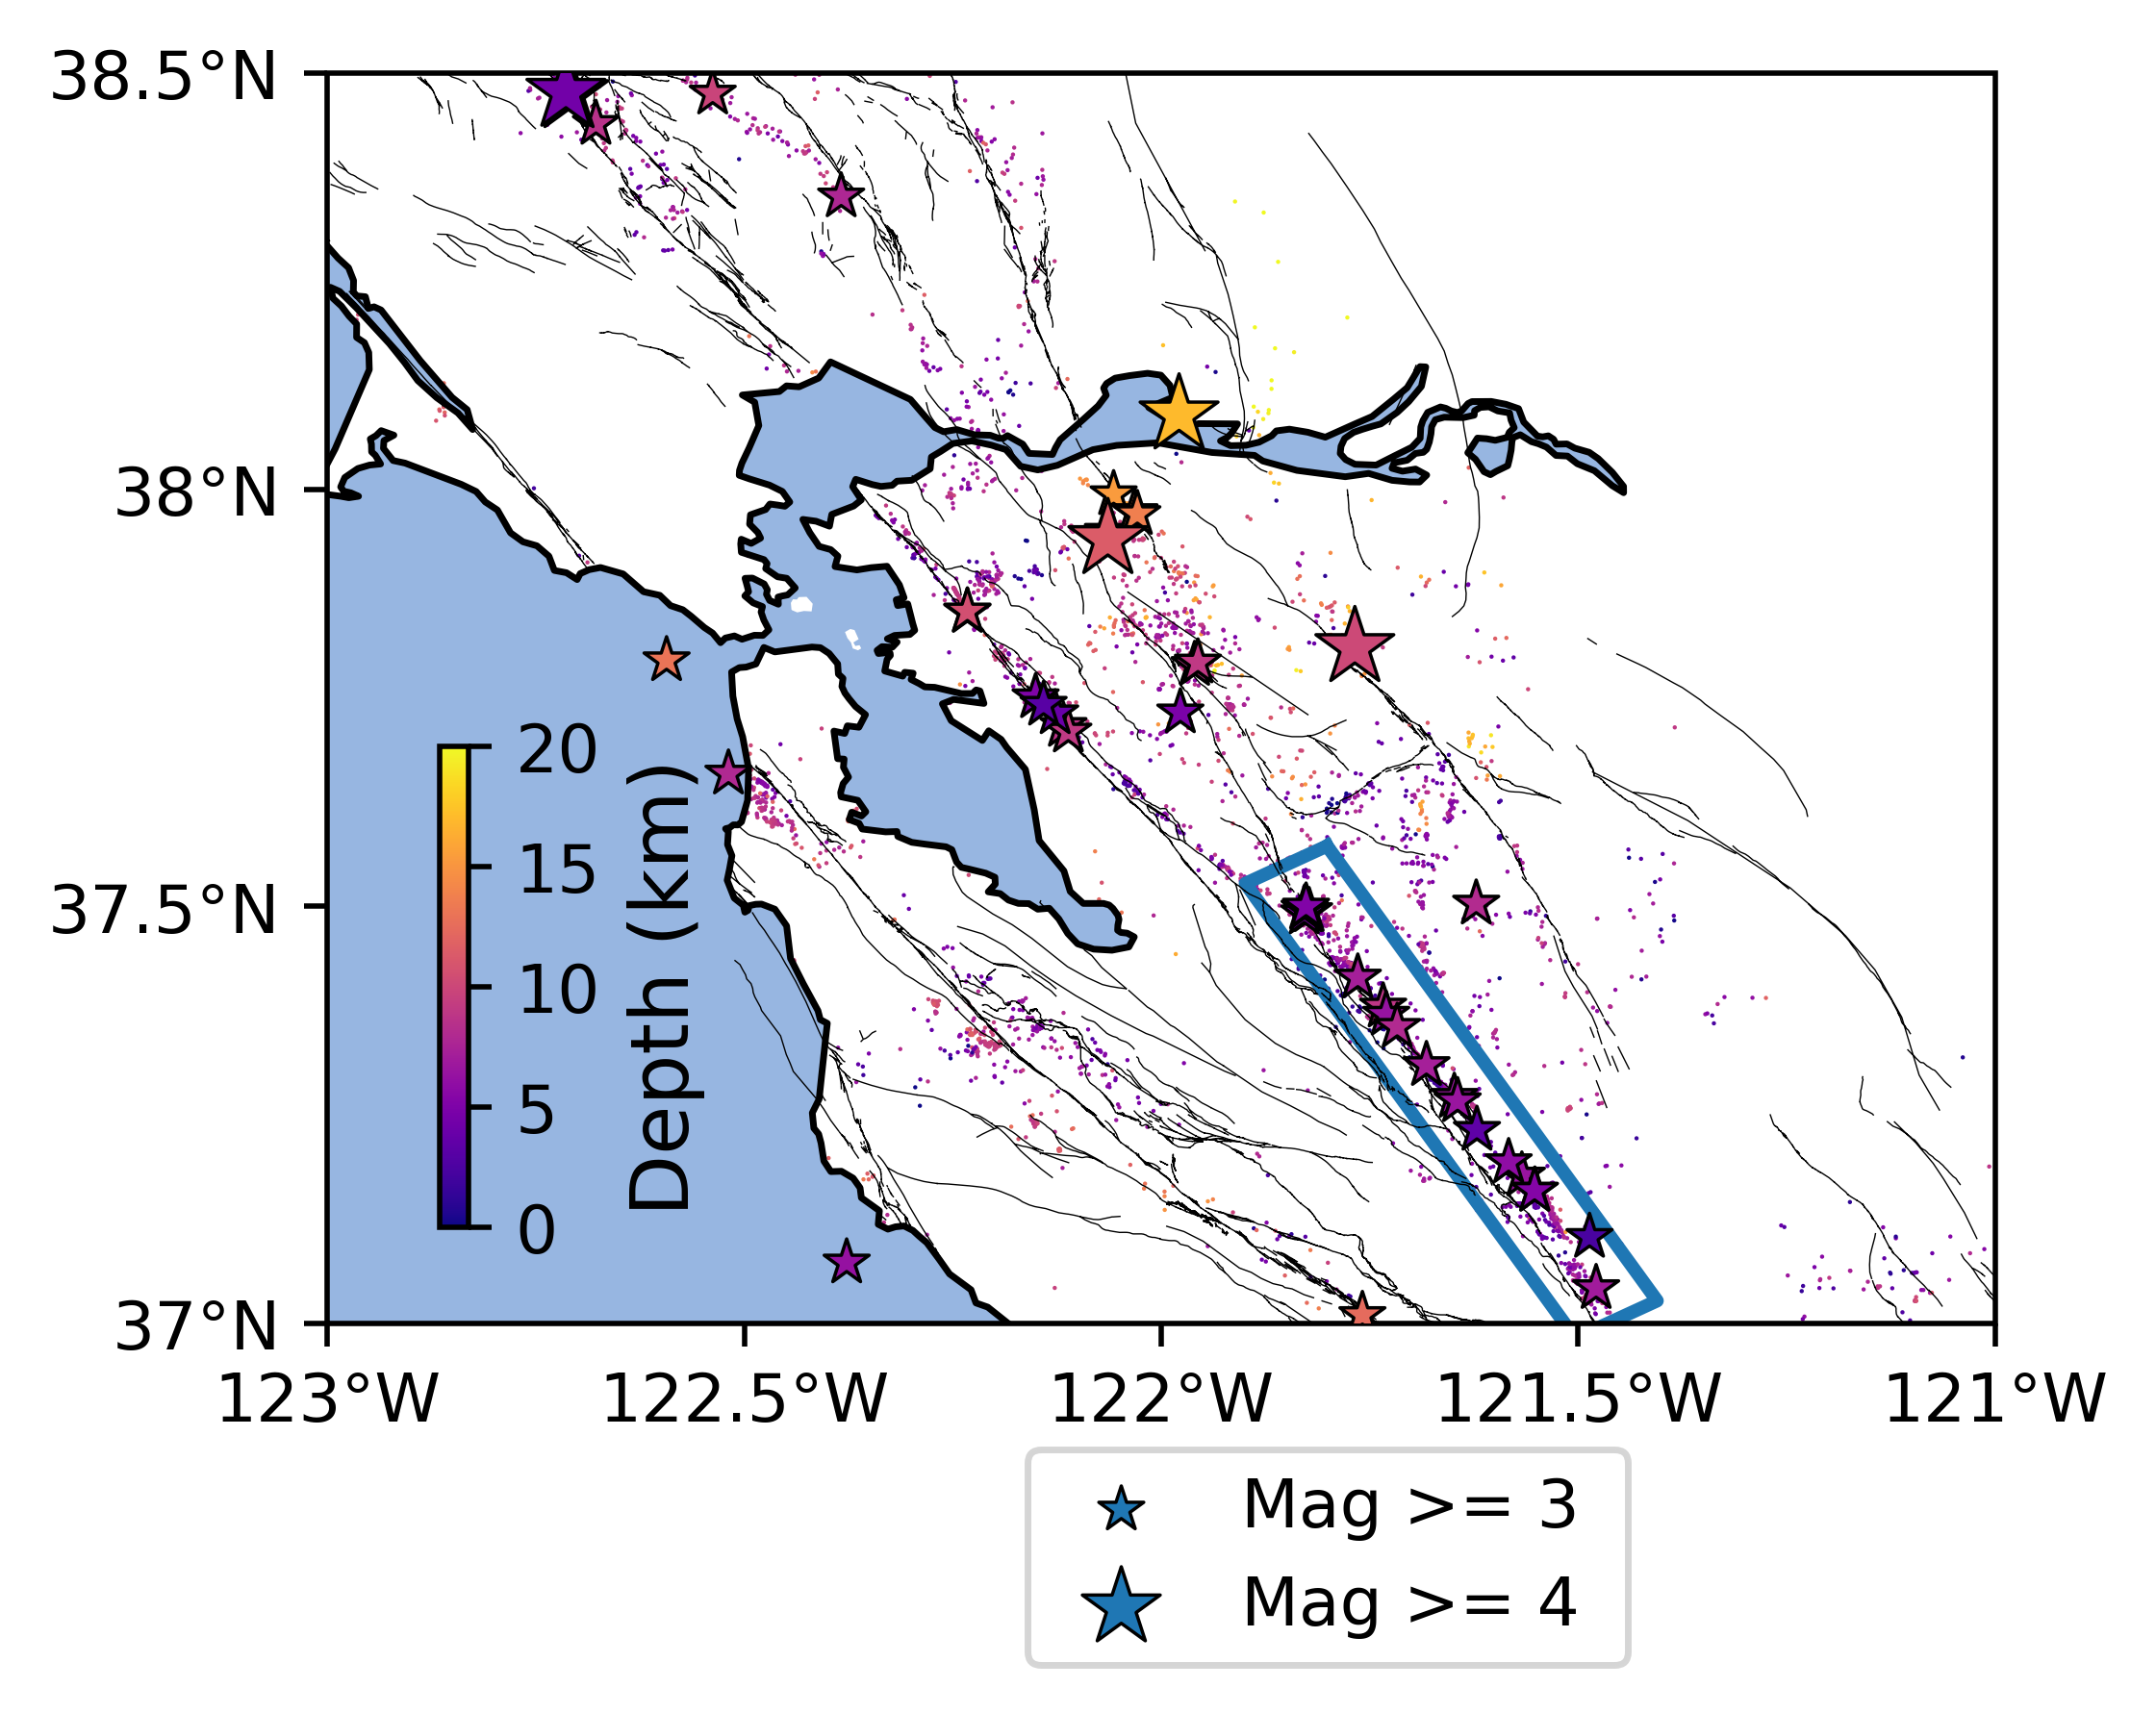

In [ ]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

lake_10m = cfeature.NaturalEarthFeature('physical', 'lakes', '10m',
                                        edgecolor='k',
                                         linewidth=0.5,
                                        facecolor=cfeature.COLORS['water'])

provinces_10m = cfeature.NaturalEarthFeature('cultural',
                                             'admin_1_states_provinces_lines',
                                             '10m',
                                             facecolor='none')
oceans_10m = cfeature.NaturalEarthFeature('physical',
                                             'ocean',
                                             '10m',
                                             facecolor=cfeature.COLORS['water'])

fig=plt.figure()
ax = fig.add_axes([0, 0, 1, 0.65], projection=ccrs.PlateCarree())
index = np.where(mag>=3)
ax.scatter(lon[index],lat[index],marker='*',s=50,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 3')
index = np.where(mag>=4)
ax.scatter(lon[index],lat[index],marker='*',s=150,lw=0.5,cmap='plasma',edgecolors='k',c=dep[index],zorder=5, \
              vmin=0,vmax=20,label='Mag >= 4 ')
im = ax.scatter(lon,lat,c=dep,s=0.4,edgecolors='none',cmap='plasma', \
               vmin=0,vmax=20)
ax.legend(bbox_to_anchor=(0.8,-0.3))

ax.set_yticks(np.arange(37,38.5+0.1,0.5))
ax.set_xticks(np.arange(-123,-121+0.1,0.5))
ax.plot(qfault[:,1],qfault[:,0],lw=0.2,c='k',zorder=3)


ax.plot(box_coor_proj[:,1],box_coor_proj[:,0],lw=2)
lon_formatter = LongitudeFormatter(number_format='g',dateline_direction_label=True)
lat_formatter = LatitudeFormatter(number_format='g')
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_ylim(37,38.5)
ax.set_xlim(-123,-121)


ax.add_feature(lake_10m)
ax.add_feature(oceans_10m)
ax.add_feature(provinces_10m)
ax.add_feature(cfeature.BORDERS)
ax.coastlines('10m')

cax1 = fig.add_axes([0.25, 0.05, 0.01, 0.25])
cbar=fig.colorbar(im,cax=cax1,fraction=0.04, pad=0.03,
                  label='Depth (km)',ticks=[0,5,10,15,20])
cbar.set_label(label='Depth (km)',fontsize=12)



# Step 1.4 overview of the selected data

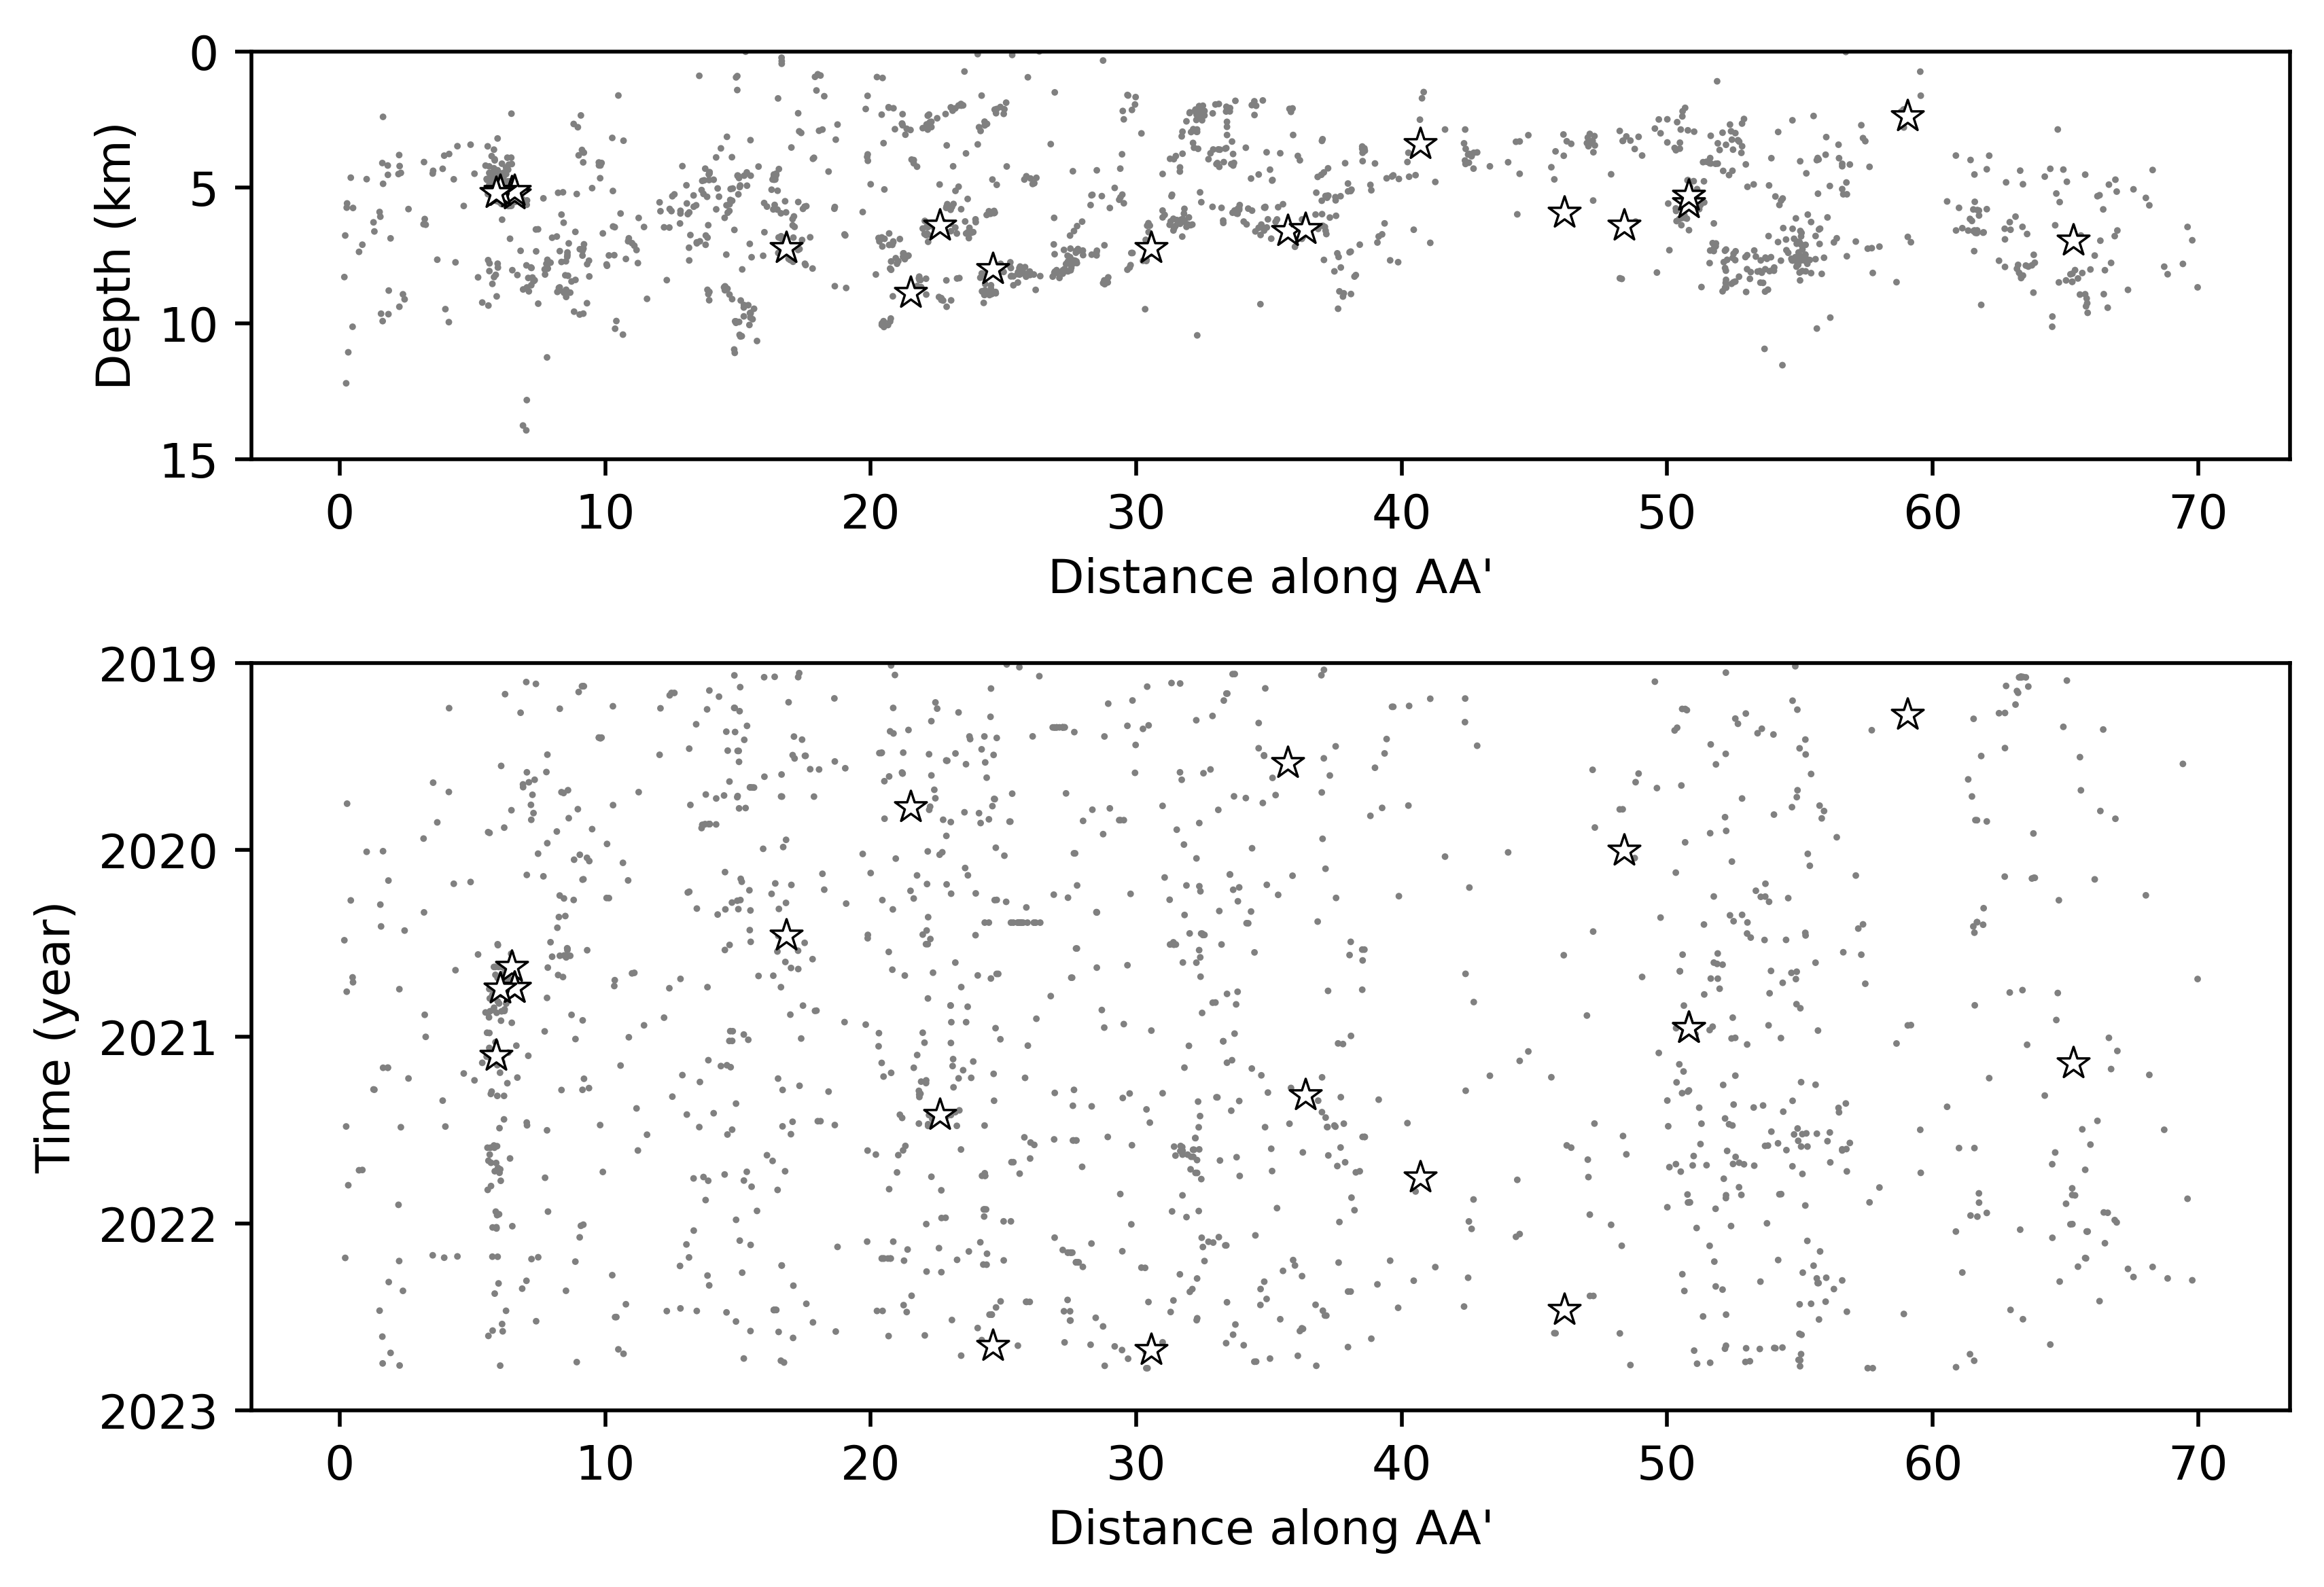

In [ ]:

fig = plt.figure()
ax = fig.add_axes([0, 0.7, 1, 0.3])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],dep[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=3))[0]
ax.scatter(dist_along_proj[index_M],dep[index_M],c='w',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(15,0)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Depth (km)")

ax = fig.add_axes([0, 0, 1, 0.55])
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]
ax.scatter(dist_along_proj[index],time_year[index],c='gray',s=2,edgecolors='none')
index_M = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&
                   (dist_norm_proj<5)&(dist_norm_proj>-5)&(mag>=3))[0]
ax.scatter(dist_along_proj[index_M],time_year[index_M],c='w',s=50,edgecolors='k',lw=0.5,marker='*')
ax.set_ylim(2023,2019)
ax.set_xlabel("Distance along AA'")
ax.set_ylabel("Time (year)")

plt.show()

# Step 2.1 calculate B-value

In [ ]:
def calc_Mc_b(mag,plot=0):
    nNumberMagnitude=np.floor(mag.max()*10)+1
    xx=np.linspace(np.floor(mag.min()*10)/10,mag.max(),int((np.floor(mag.max()*10)/10-
                                                            np.floor(mag.min()*10)/10)*10)+1)
    vhist,vMagBins=np.histogram(mag,bins=xx)
    iMc = np.where(vhist==vhist.max())[0][-1]
    fMc=vMagBins[iMc]
    hist = vhist[iMc:][::-1]
    bins = vMagBins[iMc:][::-1]
    cum_hist = hist.cumsum()
    log_cum_sum = np.log10(cum_hist)
    bins = bins[1:]
    b,a = np.polyfit(bins, log_cum_sum, 1)
    if plot==1:
        plt.figure()
        plt.subplot(211)
        plt.bar(vMagBins[:-1]+0.05,vhist,0.1)
        plt.axvline(x=fMc,c='r',lw=2)
        plt.title('Mc:'+ "{:.2f}".format(fMc)+'  '+'b value:'+  "{:.2f}".format(-b))
        plt.xlim(-1,8)
        plt.ylabel('Event number')
        plt.subplot(212)
        plt.plot(bins,np.log10(cum_hist))
        plt.plot(bins,a + b*bins)
        plt.xlim(-1,8)
        plt.xlabel('Magnitude')
        plt.ylabel('log10(CDF)')
        plt.show()
        
    return fMc, a, -b

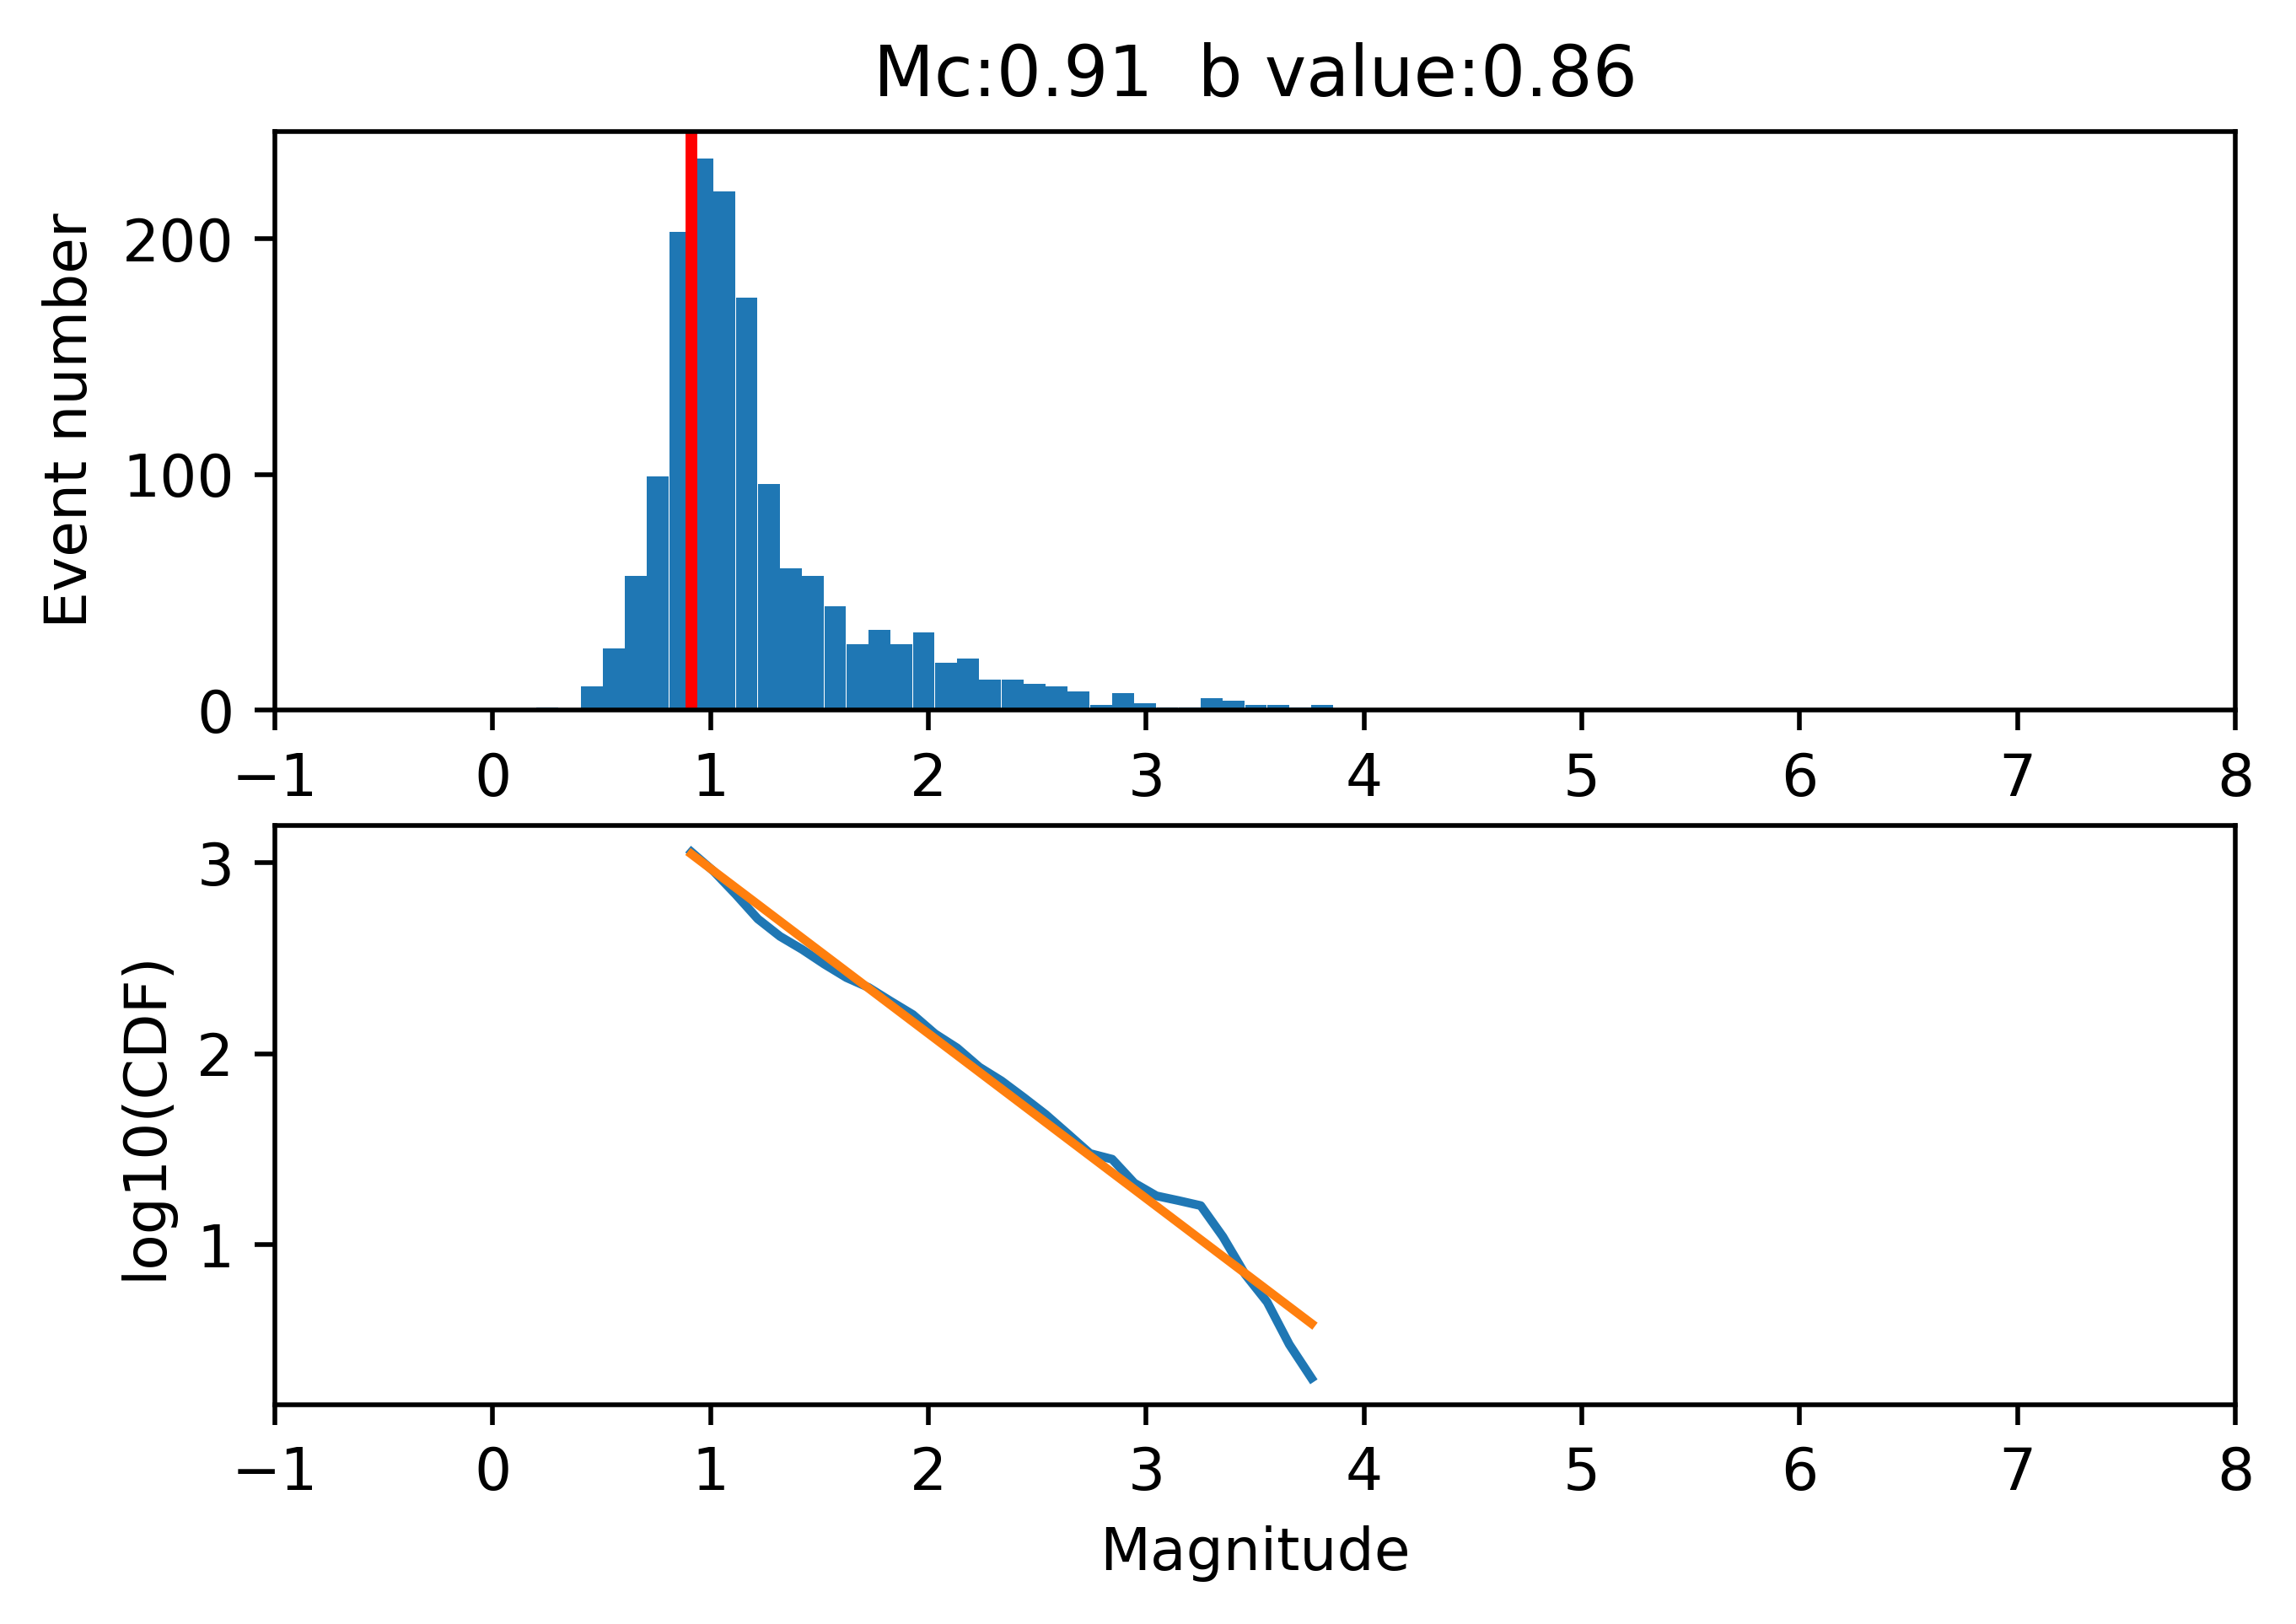

(0.9116666666666666, 3.8312941524465596, 0.8632698574614255)

In [ ]:
index = np.where((dist_along_proj<mdist_proj)&(dist_along_proj>0)&(dist_norm_proj<5)&(dist_norm_proj>-5))[0]

calc_Mc_b(mag[index],plot=1)

# Step 2.2 calculate B-value in different spatial bins and plot

# Step 2.3 calculate B-value in different time window and plot